In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

C:\Users\GobatoH\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_excel('S&P 500 Realized Volatility.xlsx',index_col='Date',parse_dates=True)


<AxesSubplot:xlabel='Date'>

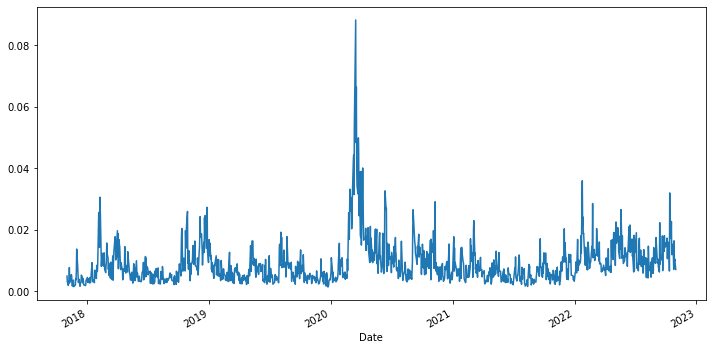

In [3]:
df["Realised"].plot(figsize=(12,6))

C:\Users\GobatoH\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


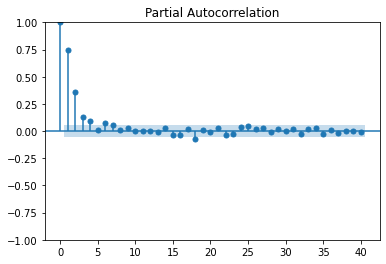

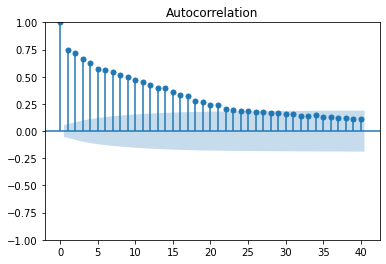

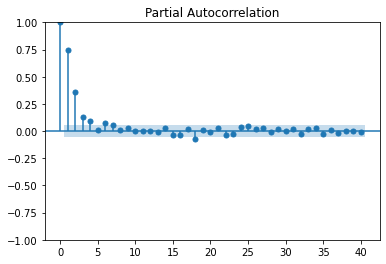

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df["Realised"], lags = 40) 
plot_pacf(df["Realised"], lags = 40, method = "ols")

Augmented Dickey Fuller test

In [5]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["Realised"])

(-5.495513264533508,
 2.1278775855352205e-06,
 6,
 1250,
 {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
 -9874.741362433027)

In [6]:
len(df["Realised"])


1257

Breusch Godfrey test

In [12]:
df_for_Breusch_Godfrey_test = df.reset_index(drop=True)

In [38]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:1256]

In [39]:
for i in range(len(y)-1):
    y[i]=y[i+1]

In [40]:
y=y[:1256]

In [41]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [42]:
import statsmodels.stats.diagnostic as dg

In [43]:
print(dg.acorr_breusch_godfrey(model, nlags=10))

(200.00936707355288, 1.6066871993650066e-37, 23.54552209278365, 6.294179403266766e-41)


Ljung-Box Test

In [86]:
def sac(x, k=1):
    """
    Sample autocorrelation (As used in statistics with normalization)
    http://en.wikipedia.org/wiki/Autocorrelation
    Parameters
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [87]:
h, pV, Q, cV = lbqtest(y, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000   1256.845      2.706      True
2       0.000   2513.256      4.605      True
3       0.000   3768.978      6.251      True
4       0.000   5025.619      7.779      True
5       0.000   6279.588      9.236      True
6       0.000   7533.304     10.645      True
7       0.000   8787.219     12.017      True
8       0.000  10040.577     13.362      True
9       0.000  11292.701     14.684      True
10      0.000  12543.434     15.987      True
11      0.000  13785.595     17.275      True
12      0.000  15025.001     18.549      True
13      0.000  16259.226     19.812      True
14      0.000  17471.565     21.064      True
15      0.000  18682.715     22.307      True
16      0.000  19892.656     23.542      True
17      0.000  21102.279     24.769      True
18      0.000  22310.701     25.989      True
19      0.000  23519.129     27.204      True


In [89]:
from pandas.plotting import lag_plot

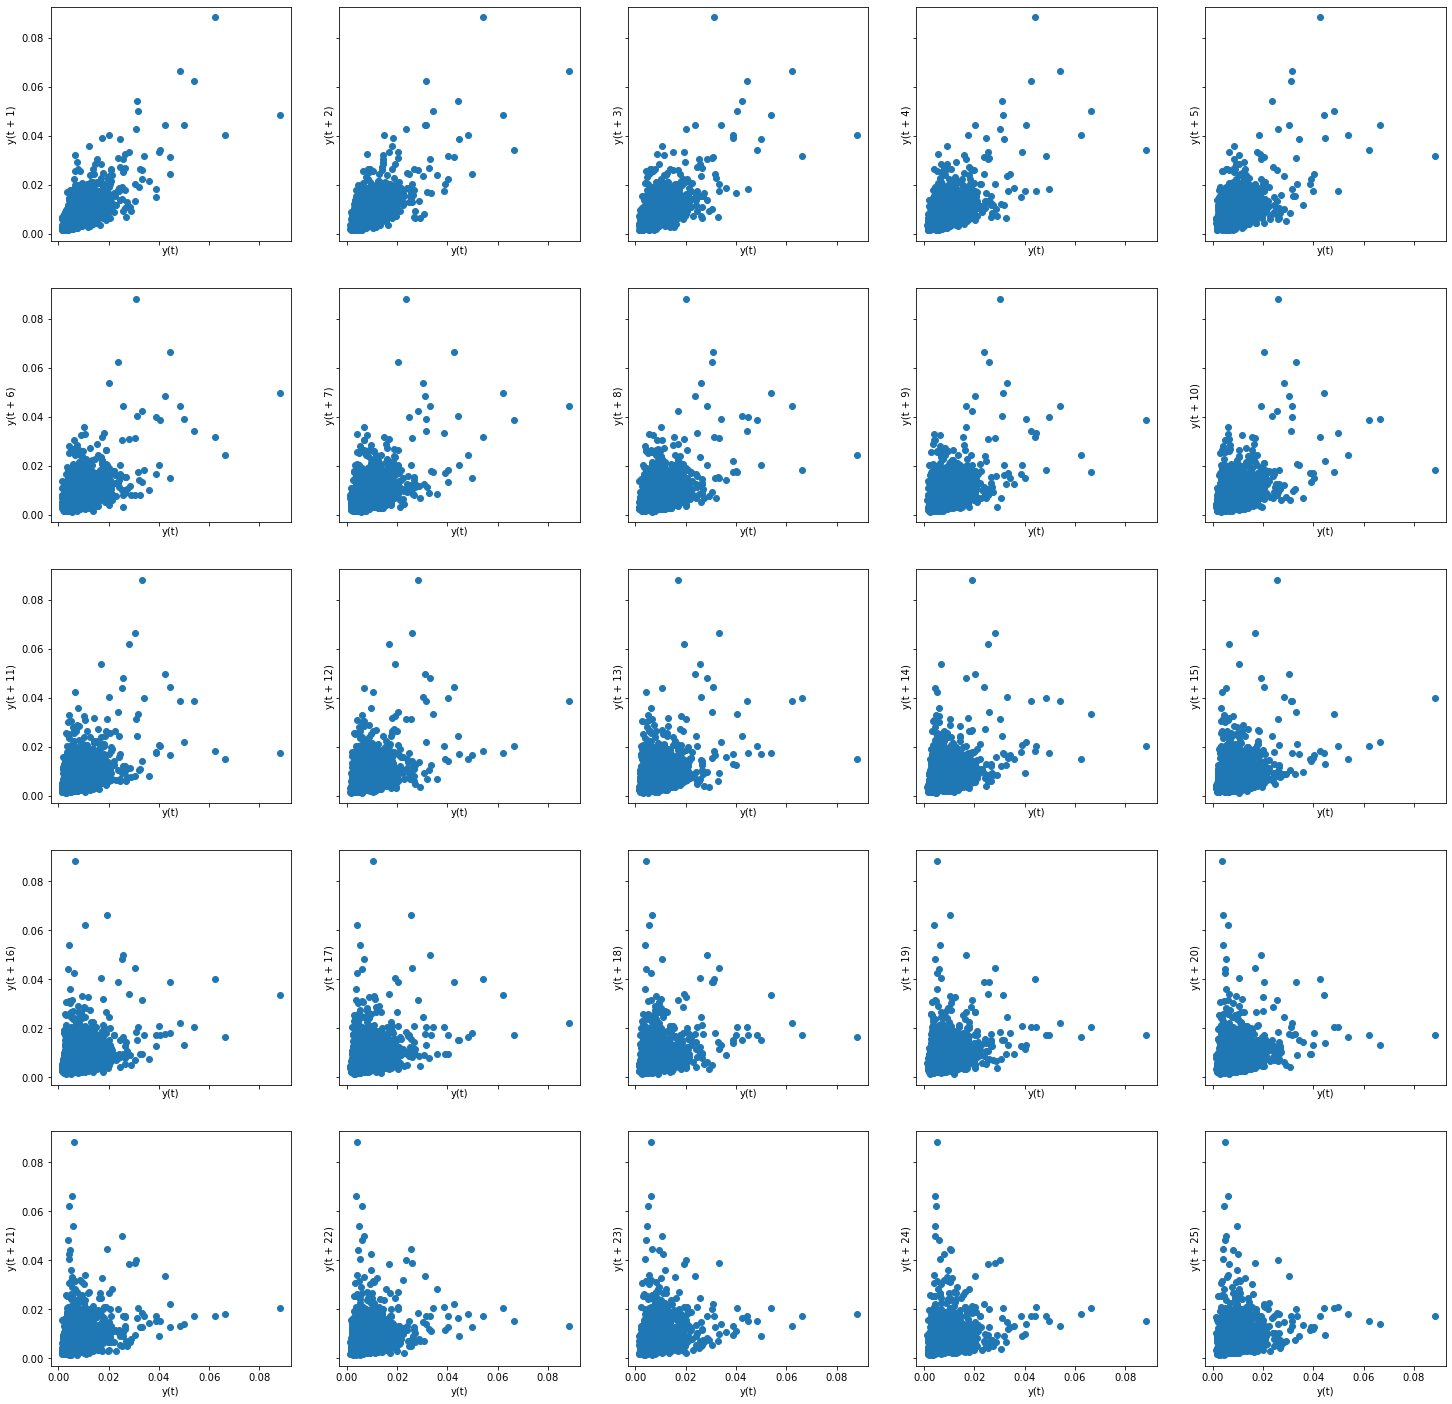

In [90]:
plot_lags = 25
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df["Realised"], lag=count, ax=axes[i, j])
        count+=1

Model Inputs Selection

In [5]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [6]:
n_inputs = [21,63,84,126,189,252]
n_neurons = [14,42,56,84,126,168]
RMSE = []
Accuracy = []
scaler = MinMaxScaler()

Determining the number of inputs

First trial

In [56]:
for m in range (1):
    for i in range (6):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
884/884 [==============================] - 7s 5ms/step - loss: 0.0037
Epoch 2/2
1/1 [==============================] - 0s 20ms/step
Epoch 1/2
842/842 [==============================] - 14s 15ms/step - loss: 0.0047
Epoch 2/2
1/1 [==============================] - 0s 23ms/step
Epoch 1/2
821/821 [==============================] - 22s 24ms/step - loss: 0.0046
Epoch 2/2
1/1 [==============================] - 0s 62ms/step
Epoch 1/2
779/779 [==============================] - 37s 41ms/step - loss: 0.0045
Epoch 2/2
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 1/2
716/716 [==============================] - 38s 51ms/step - loss: 0.0048
Epoch 2/2
1/1 [==============================] - 0s 28ms/step


In [57]:
RMSE

[0.0008693076099401873,
 0.0010767293904969193,
 0.0007687460726816601,
 0.0007561293528393268,
 0.0012665696145978025]

In [58]:
Accuracy

[38.46764174156685,
 21.513526547105556,
 52.66258280109698,
 59.63364723962214,
 8.381658459555252]

Second trial

In [64]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (5):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
884/884 [==============================] - 8s 7ms/step - loss: 0.0042
Epoch 2/2
1/1 [==============================] - 0s 21ms/step
Epoch 1/2
842/842 [==============================] - 14s 14ms/step - loss: 0.0042
Epoch 2/2
1/1 [==============================] - 0s 22ms/step
Epoch 1/2
821/821 [==============================] - 17s 19ms/step - loss: 0.0041
Epoch 2/2
1/1 [==============================] - 0s 21ms/step
Epoch 1/2
779/779 [==============================] - 26s 31ms/step - loss: 0.0042
Epoch 2/2
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 1/2
716/716 [==============================] - 36s 49ms/step - loss: 0.0046
Epoch 2/2
1/1 [==============================] - 0s 32ms/step


In [65]:
RMSE

[0.0007576715611827527,
 0.0007648092883118585,
 0.0007821562462929733,
 0.0007357204281760938,
 0.0007816952256176914]

In [66]:
Accuracy

[55.401081404246085,
 62.763611557541346,
 59.34469749972181,
 60.72997126993127,
 48.78955635135435]

Third trial

In [7]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (5):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
884/884 [==============================] - 10s 9ms/step - loss: 0.0053
Epoch 2/2
1/1 [==============================] - 0s 28ms/step
Epoch 1/2
842/842 [==============================] - 18s 19ms/step - loss: 0.0047
Epoch 2/2
1/1 [==============================] - 0s 24ms/step
Epoch 1/2
821/821 [==============================] - 18s 19ms/step - loss: 0.0039
Epoch 2/2
1/1 [==============================] - 0s 25ms/step
Epoch 1/2
779/779 [==============================] - 37s 45ms/step - loss: 0.0043
Epoch 2/2
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step
Epoch 1/2
716/716 [==============================] - 41s 54ms/step - loss: 0.0051
Epoch 2/2
1/1 [==============================] - 0s 31ms/step


In [8]:
RMSE

[0.0010759370120722888,
 0.001011343278073733,
 0.0007620204908006517,
 0.0009879680712465936,
 0.0007895673502746294]

In [9]:
Accuracy

[20.332100954848332,
 58.38829753260563,
 52.29104036868462,
 28.624987550103953,
 51.877789380302254]

Fourth trial

In [10]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (5):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
884/884 [==============================] - 8s 7ms/step - loss: 0.0040
Epoch 2/2
1/1 [==============================] - 0s 26ms/step
Epoch 1/2
842/842 [==============================] - 16s 16ms/step - loss: 0.0055
Epoch 2/2
1/1 [==============================] - 0s 24ms/step
Epoch 1/2
821/821 [==============================] - 22s 25ms/step - loss: 0.0038
Epoch 2/2
1/1 [==============================] - 0s 24ms/step
Epoch 1/2
779/779 [==============================] - 28s 34ms/step - loss: 0.0042
Epoch 2/2
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step
Epoch 1/2
716/716 [==============================] - 40s 54ms/step - loss: 0.0046
Epoch 2/2
1/1 [==============================] - 0s 33ms/step


In [11]:
RMSE

[0.0009132767403631179,
 0.0008254785997251423,
 0.0007573151658951296,
 0.0011731339447473837,
 0.0008238739052117726]

In [12]:
Accuracy

[35.462514098377575,
 43.85999390411756,
 61.7958033985234,
 14.23607729281554,
 43.7277346472415]

Fifth trial

In [13]:
RMSE = []
Accuracy = []
for m in range (1):
    for i in range (5):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[i]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[i], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
884/884 [==============================] - 6s 5ms/step - loss: 0.0048
Epoch 2/2
1/1 [==============================] - 0s 20ms/step
Epoch 1/2
842/842 [==============================] - 17s 18ms/step - loss: 0.0046
Epoch 2/2
1/1 [==============================] - 0s 24ms/step
Epoch 1/2
821/821 [==============================] - 18s 20ms/step - loss: 0.0042
Epoch 2/2
1/1 [==============================] - 0s 22ms/step
Epoch 1/2
779/779 [==============================] - 27s 32ms/step - loss: 0.0040
Epoch 2/2
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 1/2
716/716 [==============================] - 57s 77ms/step - loss: 0.0049
Epoch 2/2
1/1 [==============================] - 0s 37ms/step


In [14]:
RMSE

[0.0008280286636149919,
 0.0008718228557600012,
 0.0007489857941376614,
 0.0007486756059311305,
 0.001165915218985806]

In [15]:
Accuracy

[44.73173618019568,
 39.14869195859385,
 58.590903521758555,
 61.251095729146044,
 14.660163578183539]

In [16]:
# n_inputs = [21,63,84,126,189,252]
RMSE_average_validation_with_21inputs = (0.0008280286636149919+0.0009132767403631179+0.0010759370120722888+0.0007576715611827527+0.0008693076099401873)/5
print(RMSE_average_validation_with_21inputs)

0.0008888443174346677


In [17]:
RMSE_average_validation_with_63inputs = (0.0008718228557600012+0.0008254785997251423+0.001011343278073733+0.0007648092883118585+0.0010767293904969193)/5
print(RMSE_average_validation_with_63inputs)

0.000910036682473531


In [18]:
RMSE_average_validation_with_84inputs = (0.0007489857941376614+0.0007573151658951296+0.0007620204908006517+0.0007821562462929733+0.0007687460726816601)/5
print(RMSE_average_validation_with_84inputs)

0.0007638447539616152


In [19]:
RMSE_average_validation_with_126inputs = (0.0007486756059311305+0.0011731339447473837+0.0009879680712465936+0.0007357204281760938+0.0007561293528393268)/5
print(RMSE_average_validation_with_126inputs)

0.0008803254805881056


In [20]:
RMSE_average_validation_with_189inputs = (0.001165915218985806+0.0008238739052117726+0.0007895673502746294+0.0007816952256176914+0.0012665696145978025)/5
print(RMSE_average_validation_with_189inputs)

0.0009655242629375404


In [25]:
RMSE = []
Accuracy = []
for m in range (5):
        train = df.iloc[:905]
        validation = df.iloc[905:1005]
        test = df.iloc[1005:]
        scaler.fit(train)
        scaled_train_input = scaler.transform(train)
        scaled_validation_input = scaler.transform(validation)
        scaled_test_input = scaler.transform(test)
        train = df["Realised"].iloc[:905]
        validation = df["Realised"].iloc[905:1005]
        test = df["Realised"].iloc[1005:]
        train = train.array.reshape(-1, 1)
        validation = validation.array.reshape(-1, 1)
        test = test.array.reshape(-1, 1)
        scaler.fit(train)
        scaled_train_target = scaler.transform(train)
        scaled_validation_target = scaler.transform(validation)
        scaled_test_target = scaler.transform(test)
        n_features = 4
        n_input = n_inputs[5]
        generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
        model = Sequential()
        model.add(LSTM(n_neurons[5], activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator,epochs=2)
        last_train_batch = scaled_train_input[-n_input:]
        last_train_batch = last_train_batch.reshape((1, n_input, n_features))
        a = np.array(scaled_validation_input)
        test_predictions = []
        first_eval_batch = scaled_train_input[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
        for j in range(len(scaled_validation_input)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
        true_predictions = scaler.inverse_transform(test_predictions)
        RMSE.append(np.sum(np.sqrt((validation-true_predictions)**2))/len(test))
        Accuracy.append((1-(np.sum(np.sqrt((validation-true_predictions)**2)/validation)/len(validation)))*100)

Epoch 1/2
653/653 [==============================] - 44s 65ms/step - loss: 0.0047
Epoch 2/2
1/1 [==============================] - 0s 51ms/step
Epoch 1/2
653/653 [==============================] - 64s 94ms/step - loss: 0.0050
Epoch 2/2
1/1 [==============================] - 0s 40ms/step
Epoch 1/2
653/653 [==============================] - 64s 95ms/step - loss: 0.0048
Epoch 2/2
1/1 [==============================] - 0s 41ms/step
Epoch 1/2
653/653 [==============================] - 82s 122ms/step - loss: 0.0049
Epoch 2/2
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 45ms/step
Epoch 1/2
653/653 [==============================] - 63s 94ms/step - loss: 0.0047
Epoch 2/2
1/1 [==============================] - 0s 42ms/step


In [26]:
RMSE

[0.0012642745482914974,
 0.0007790564199856428,
 0.0007584987973793136,
 0.0009335604598024915,
 0.0009307433071947813]

In [27]:
Accuracy

[4.607594185641961,
 61.45313274235513,
 58.890349128507545,
 33.51528154916426,
 33.872079142432455]

In [31]:
RMSE_average_validation_with_252inputs = np.mean(RMSE)
print(RMSE_average_validation_with_189inputs)

0.0009655242629375404


In [54]:
RMSE = []
Accuracy = []

In [128]:
train = df.iloc[:1005]
test = df.iloc[1005:]
scaler.fit(train)
scaled_train_input = scaler.transform(train)
scaled_test_input = scaler.transform(test)
train = df["Realised"].iloc[:1005]
test = df["Realised"].iloc[1005:]
train = train.array.reshape(-1, 1)
test = test.array.reshape(-1, 1)
scaler.fit(train)
scaled_train_target = scaler.transform(train)
scaled_test_target = scaler.transform(test)
n_features = 4
n_input = n_inputs[2]
generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=1)
model = Sequential()
model.add(LSTM(n_neurons[2], activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
model.fit(generator,epochs=11)
last_train_batch = scaled_train_input[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
a = np.array(scaled_test_input)
test_predictions = []
first_eval_batch = scaled_train_input[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
for j in range(len(test)):
            # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
            # append the prediction into the array
    test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[a[j]]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
Accuracy.append((1-(np.sum(np.sqrt((test-true_predictions)**2)/test)/len(test)))*100)

Epoch 1/11
921/921 [==============================] - 22s 22ms/step - loss: 0.0054 - accuracy: 0.0011 - mean_absolute_error: 0.0433
Epoch 2/11
921/921 [==============================] - 20s 22ms/step - loss: 0.0042 - accuracy: 0.0011 - mean_absolute_error: 0.0407
Epoch 3/11
921/921 [==============================] - 20s 21ms/step - loss: 0.0039 - accuracy: 0.0011 - mean_absolute_error: 0.0390
Epoch 4/11
921/921 [==============================] - 19s 21ms/step - loss: 0.0037 - accuracy: 0.0011 - mean_absolute_error: 0.0388
Epoch 5/11
921/921 [==============================] - 20s 22ms/step - loss: 0.0035 - accuracy: 0.0011 - mean_absolute_error: 0.0374
Epoch 6/11
921/921 [==============================] - 19s 21ms/step - loss: 0.0036 - accuracy: 0.0011 - mean_absolute_error: 0.0381
Epoch 7/11
921/921 [==============================] - 19s 21ms/step - loss: 0.0036 - accuracy: 0.0011 - mean_absolute_error: 0.0385
Epoch 8/11
921/921 [==============================] - 18s 20ms/step - loss: 

In [132]:
Accuracy

[70.21482937968342,
 67.56343864631873,
 67.46888341227498,
 70.85994309556976,
 71.36178537107655,
 67.99698873660918,
 69.77213092467403,
 69.32285546955593,
 70.74851316802065,
 69.85829887160064,
 68.97158639483234,
 68.63091260757656,
 66.76787839647278,
 71.00594938848961,
 69.8180658321845]

In [152]:
print("mean: %s" %(round(np.mean(Accuracy),2))+"%")

mean: 69.36%


In [153]:
print("stdv: %s" %(round(np.std(Accuracy),2))+"%")

stdv: 1.37%


In [142]:
Accuracy_CI_95_lower_bound=np.mean(Accuracy)-2*np.std(Accuracy)
Accuracy_CI_95_upper_bound=np.mean(Accuracy)+2*np.std(Accuracy)
print("95 percent CI lower bound: %s" %round(Accuracy_CI_95_lower_bound,2)+"%")
print("95 percent CI upper bound: %s" %round(Accuracy_CI_95_upper_bound,2)+"%")

95 percent CI lower bound: 66.61%
95 percent CI upper bound: 72.11%


In [143]:
Accuracy_CI_99_lower_bound=np.mean(Accuracy)-3*np.std(Accuracy)
Accuracy_CI_99_upper_bound=np.mean(Accuracy)+3*np.std(Accuracy)
print("99.7 percent CI lower bound: %s" %round(Accuracy_CI_99_lower_bound,2)+"%")
print("99.7 percent CI upper bound: %s" %round(Accuracy_CI_99_upper_bound,2)+"%")

99.7 percent CI lower bound: 65.24%
99.7 percent CI upper bound: 73.48%


In [130]:
RMSE

[0.0031714343598445126,
 0.0031293752729225654,
 0.003158289729794266,
 0.00339571193555375,
 0.003216944922310024,
 0.003184823541827715,
 0.0031704062853150938,
 0.0032919006914420537,
 0.003407280948411402,
 0.003635326668303067,
 0.003156606539769098,
 0.00319132705206176,
 0.0031247388859248744,
 0.003247568307656642,
 0.003206066240920552]

In [150]:
print("mean: %s" %(round(np.mean(RMSE),5)*100)+"%")

mean: 0.325%


In [151]:
print("stdv: %s" %(round(np.std(RMSE),5)*100)+"%")

stdv: 0.013%


In [158]:
RMSE_CI_95_lower_bound=np.mean(RMSE)-2*np.std(RMSE)
RMSE_CI_95_upper_bound=np.mean(RMSE)+2*np.std(RMSE)
print("95 percent CI lower bound: %s" %(round(RMSE_CI_95_lower_bound,5)*100)+"%")
print("95 percent CI upper bound: %s" %(round(RMSE_CI_95_upper_bound,5)*100)+"%")

95 percent CI lower bound: 0.298%
95 percent CI upper bound: 0.35100000000000003%


In [159]:
RMSE_CI_99_lower_bound=np.mean(RMSE)-3*np.std(RMSE)
RMSE_CI_99_upper_bound=np.mean(RMSE)+3*np.std(RMSE)
print("99.7 percent CI lower bound: %s" %(round(RMSE_CI_99_lower_bound,5)*100)+"%")
print("99.7 percent CI upper bound: %s" %(round(RMSE_CI_99_upper_bound,5)*100)+"%")

99.7 percent CI lower bound: 0.28500000000000003%
99.7 percent CI upper bound: 0.365%


Text(0, 0.5, 'S&P 500 Realized Volatility')

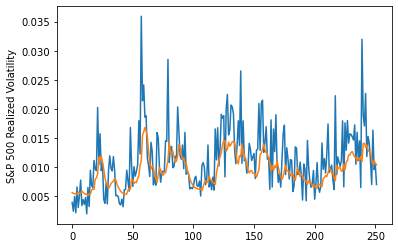

In [127]:
# Best model
plt.plot(range(252), test)
plt.plot(range(252), true_predictions) 
plt.ylabel("S&P 500 Realized Volatility")

In [55]:
n_inputs = [21,63,84,126,189,252]
n_neurons = [14,42,56,84,126,168]
RMSE = []
Accuracy = []
scaler = MinMaxScaler()